# Tutorial 8: Re-Construyendo Nuestra Red Neuronal Parte 2
## Objectivos
- En este tutorial usaremos tecnicas de regularización y normalización que dejamos pendiente en el tutorial pasado.

## Repaso materia
-  Batch Normalization
- Regularización L1-L2
- Weight Decay (Decaimiento de Peso)


In [1]:
from sklearn.datasets import load_iris
import torch

data = load_iris()

train_data = data['data']
train_traget = data['target']

# Infelizmente el analisis de como són los datos no es tan rapido, por ende ire explicar las decisiones que tome.


print(train_traget[0])

X = torch.tensor(train_data, dtype=torch.float32)
y = torch.tensor(train_traget, dtype=torch.long)


0


In [2]:
import pandas as pd
import random

df = pd.DataFrame(train_data)
df['class'] = train_traget
# mean maxium and minum for each column by class
result = df.groupby('class').agg([min, max, 'mean', 'std'])

new_sample = []
for i in range(4):
    new_sample.append(result[i]['mean'][1] + random.uniform(-result[i]['std'][1]**2, result[i]['std'][1]**2))
                    
print(new_sample)
result

[5.7336370566323644, 2.8392605198426306, 4.221587814544018, 1.3594939311882535]


0                          1                          2              \
       min  max   mean       std  min  max   mean       std  min  max   mean   
class                                                                          
0      4.3  5.8  5.006  0.352490  2.3  4.4  3.428  0.379064  1.0  1.9  1.462   
1      4.9  7.0  5.936  0.516171  2.0  3.4  2.770  0.313798  3.0  5.1  4.260   
2      4.9  7.9  6.588  0.635880  2.2  3.8  2.974  0.322497  4.5  6.9  5.552   

                   3                        
            std  min  max   mean       std  
class                                       
0      0.173664  0.1  0.6  0.246  0.105386  
1      0.469911  1.0  1.8  1.326  0.197753  
2      0.551895  1.4  2.5  2.026  0.274650

# Ahora iremos poblar el dataset con nuestros ejemplos sinteticos

In [3]:
# create 1000 new samples for each class
new_samples = []
for i in range(3):
    for j in range(1000):
        new_sample = []
        for k in range(4):
            new_sample.append(result[k]['mean'][i] + random.uniform(-result[k]['std'][i]**2, result[k]['std'][i]**2))
        new_sample.append(i)
        new_samples.append(new_sample)

# add new samples to the original df
new_df = pd.DataFrame(new_samples, columns=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'class'])
new_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.112871,3.549960,1.461188,0.247820,0
1,5.089975,3.358845,1.475838,0.250204,0
2,5.041949,3.497910,1.437546,0.256577,0
3,4.952852,3.456821,1.469184,0.245800,0
4,5.071051,3.311539,1.480196,0.237391,0
...,...,...,...,...,...
2995,6.705265,3.021968,5.834926,2.058247,2
2996,6.505716,2.999915,5.447413,1.990644,2
2997,6.936767,2.902201,5.573469,2.087448,2
2998,6.440282,2.885244,5.562013,1.974762,2


In [4]:
#from new df create new X and y
new_X = torch.tensor(new_df.drop('class', axis=1).values, dtype=torch.float32)
new_y = torch.tensor(new_df['class'].values, dtype=torch.long)

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)

        # Batch normalization layer
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        x = self.fc1(x) # 4 -> 128
        x = self.bn1(x) # Them we apply the batch normalization
        x = F.relu(x)
        
        x = self.fc2(x) 
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x) # The Dropout is for each layer and the probability is 0.5, this means that 50% of the neurons will be "droped"
        
        x = self.fc3(x)
        return x


In [17]:
from torch.optim import SGD

model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.17, weight_decay=0.01)

epoch_loss = []

for epoch in range(1000):
    optimizer.zero_grad()
    output = model(new_X)
    loss = criterion(output, new_y)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    epoch_loss.append(loss.item())
print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 1.102020025253296
Epoch 101, Loss: 0.003803747706115246
Epoch 201, Loss: 0.0014798174379393458
Epoch 301, Loss: 0.0011318615870550275
Epoch 401, Loss: 0.0008099554106593132
Epoch 501, Loss: 0.0005508100730367005
Epoch 601, Loss: 0.0004989450098946691
Epoch 701, Loss: 0.00037300726398825645
Epoch 801, Loss: 0.00028158005443401635
Epoch 901, Loss: 0.0002809526340570301
Epoch 1000, Loss: 0.00029334492865018547


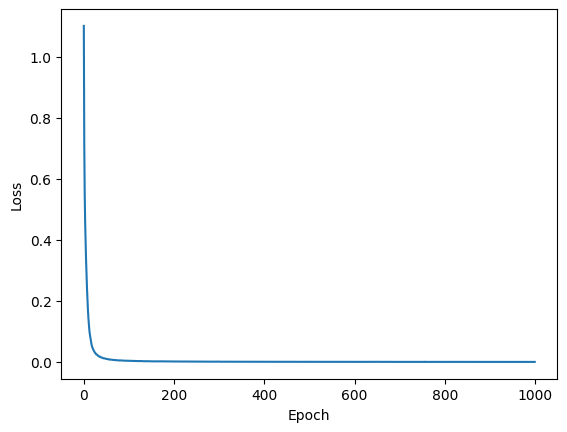

Accuracy: 84.66666666666667%


In [19]:

import matplotlib.pyplot as plt
plt.plot(epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

test_losses = []

import torch.nn.functional as F

with torch.no_grad():
    # Forward pass
    outputs = model(X)
    
    # Apply Softmax to get probabilities
    probabilities = F.softmax(outputs, dim=1)
    
    # Get the predicted class
    _, predicted_class = torch.max(probabilities, 1)

correct = (predicted_class == y).sum().item()
total = y.size(0)
accuracy = correct / total
print(f'Accuracy: {accuracy * 100}%')

